# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**План работы:**

- вначале я проведу преодобработку данных;
- затем обучу выбранные мною модели;
- в итоге сравню важные для заказчика показатели и выберу оптимальную модель для предсказания стоимости автомобиля. 

## Подготовка данных

### Загрузка данных и подключение библиотек

#pip install lightgbm   
#pip install ipywidgets   
#pip install catboost

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import time
from matplotlib import pyplot as plt

# импорт метрики качества 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# импорт для предобработки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder # добавила

# импорт моделей 
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение данных
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

### Предобработка данных 

Здесь проверю наличие:  
* миссингов;  
* выбросов;  
* дублей.

Затем: 
* приму решение по поводу миссингов, если будут - удалю, оставлю как есть или попробую импутировать;  
* приму решение по поводу выбросов, если будут - удалю или оставлю как есть;  
* удалю дубли при их наличии.

Далее:  
* масштабирую данные;  
* перекодирую категориальные переменные.  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Краткий вывод**

В нашем датасете 16 столбцов: 15 признаков и 1 целевой признак. 

*Признаки*
* `DateCrawled` — дата скачивания анкеты из базы  
* `VehicleType` — тип автомобильного кузова  
* `RegistrationYear` — год регистрации автомобиля  
* `Gearbox` — тип коробки передач  
* `Power` — мощность (л. с.)  
* `Model` — модель автомобиля  
* `Kilometer` — пробег (км)  
* `RegistrationMonth` — месяц регистрации автомобиля  
* `FuelType` — тип топлива  
* `Brand` — марка автомобиля  
* `NotRepaired` — была машина в ремонте или нет  
* `DateCreated` — дата создания анкеты  
* `NumberOfPictures` — количество фотографий автомобиля  
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)  
* `LastSeen` — дата последней активности пользователя  


Названия переменных не соответствуют нижнему регистру. Приведу названия столбцов к нижнему регистру. 

In [4]:
data.rename(columns={"DateCrawled": "Date_Crawled", 
                     "VehicleType": "Vehicle_Type",
                     "RegistrationYear": "Registration_Year",
                     "RegistrationMonth": "Registration_Month",
                     "FuelType": "Fuel_Type",
                     "NotRepaired": "Not_Repaired",
                     "DateCreated": "Date_Created",
                     "NumberOfPictures": "Number_Of_Pictures",
                     "PostalCode": "Postal_Code",
                     "LastSeen": "Last_Seen"}, inplace = True)
data.columns = data.columns.str.lower()

In [5]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Привела к единому нижнему регистру. Посмотрим сколько в данных миссингов.

Далее заметим, что признаки `registration_year`, `registration_month` и `postal_code` хорошо бы перекодировать в тип категориальных переменных. 

In [6]:
# посмотрим сколько уникальных значений в registration_year
len(data['registration_year'].unique())

151

В этой переменной 138 уникальных годов. Ну что же делать... Оставлять эту переменную в виде числовой и работать с ней как с числовой не имеет смысла. 

In [7]:
# посмотрим сколько уникальных значений в registration_month
len(data['registration_month'].unique())

13

Так, странно... 13 месяцев? 🤔

Посмотрим ближе 

In [8]:
data['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [9]:
data['registration_month'].value_counts(sort=False)

0     37352
1     23219
2     21267
3     34373
4     29270
5     29153
6     31508
7     27213
8     22627
9     23813
10    26099
11    24186
12    24289
Name: registration_month, dtype: int64

Очень странные значения. Но видимо придется работать с этим как есть. 

In [10]:
data['registration_month'] = data['registration_month'].astype(str)
data['registration_year'] = data['registration_year'].astype(str)
data['postal_code'] = data['postal_code'].astype(str)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  object
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  object
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  object
 15  last_seen           354369 non-null  object
dtypes:

Отлично, перекодировали. Идем дальше.

#### Миссинги

In [12]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [13]:
def pass_value(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = False)
        .plot(kind= 'bar', figsize=(19,3), rot = 10, legend = False)
        .set_title('Число миссингов' + "\n", fontsize = 20, color = 'SteelBlue') # чуть добавил
    );

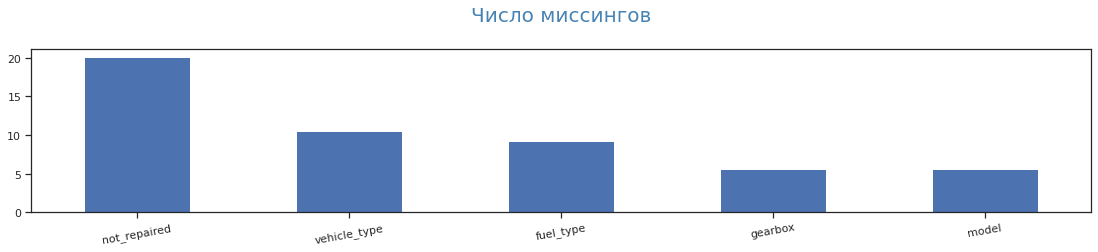

In [14]:
sns.set_theme(style="ticks")
# изобразим долю пропусков
pass_value(data)

**Краткий вывод**

В данных есть миссинги в категориальных переменных (типа object). Больше всего миссингов в признаке `not_repaired` (была машина в ремонте или нет) - почти 20%. От 10% и менее в признаках `vehicle_type` (тип автомобильного кузова), `fuel_type`(тип топлива), `gearbox` (тип коробки передач) и `model` (модель автомобиля). 

Удалять миссинги не хотелось бы, теряется много информации. Посмотрим сколько объектов, где миссинги по всем этим признакам. 

In [15]:
data.loc[data['not_repaired'].isna() & 
         data['vehicle_type'].isna() & 
         data['fuel_type'].isna() &  
         data['gearbox'].isna() & 
         data['model'].isna()].shape

(2237, 16)

Таких объектов 2237, что менее 1% от данных (точнее 0,63). Посмотрим чуть ближе на несколько таких объектов. 

In [16]:
data.loc[data['not_repaired'].isna() & 
         data['vehicle_type'].isna() & 
         data['fuel_type'].isna() &  
         data['gearbox'].isna() & 
         data['model'].isna()].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
522,2016-03-14 18:40:14,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,2016-03-14 00:00:00,0,25524,2016-03-14 18:40:14
538,2016-03-15 17:43:21,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,NaN,2016-03-15 00:00:00,0,94315,2016-04-06 14:45:44
552,2016-03-21 10:52:52,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,NaN,2016-03-21 00:00:00,0,69120,2016-03-22 14:50:41
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37


Думаю, что от этих данных можно спокойно избавиться. 

In [17]:
data.drop(data.loc[data['not_repaired'].isna() & 
         data['vehicle_type'].isna() & 
         data['fuel_type'].isna() &  
         data['gearbox'].isna() & 
         data['model'].isna()].index, 
         inplace=True)

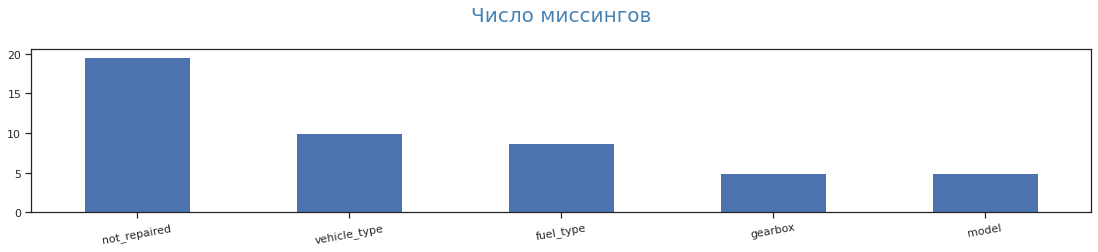

In [18]:
pass_value(data)

Миссингов все равно осталось довольно много. Заменю их при помощи `IterativeImputer`, когда поделю данные на обучающую и тестовую выборки. 

#### Выбросы 

Посмотрим насколько разброс сильный у количественных переменных. 

In [19]:
data.select_dtypes(include='number').columns

Index(['price', 'power', 'kilometer', 'number_of_pictures'], dtype='object')

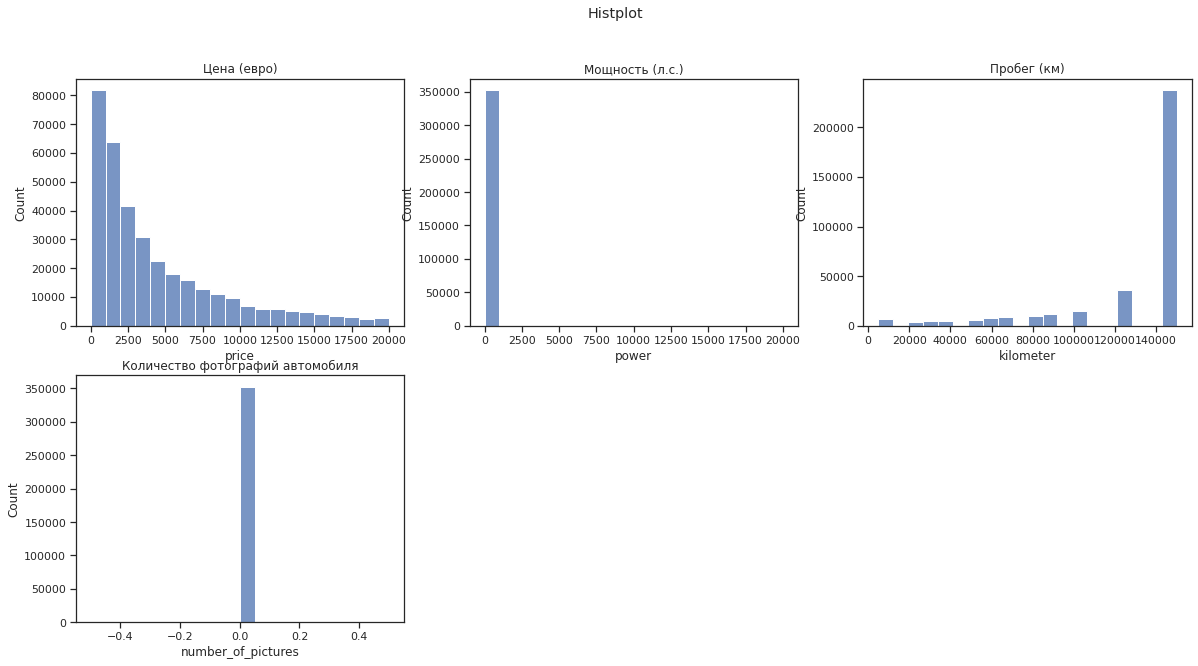

In [20]:
# посмотрим на распределения 

fig = plt.figure(figsize=(20,10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)

axes = [ax_1, ax_2, ax_3, ax_4]


sns.histplot(data['price'], ax=ax_1, bins=20)
sns.histplot(data['power'], ax=ax_2, bins=20)
sns.histplot(data['kilometer'], ax=ax_3, bins=20)
sns.histplot(data['number_of_pictures'], ax=ax_4, bins=20)

ax_1.set(title = 'Цена (евро)')
ax_2.set(title = 'Мощность (л.с.)')
ax_3.set(title = 'Пробег (км)')
ax_4.set(title = 'Количество фотографий автомобиля')

fig.suptitle('Histplot');

**Краткий вывод** 

Первое, что бросается в глаза, это гистрограмма признака `number_of_pictures`. Убедимся, что там действительно нулевые значения. 

In [21]:
data['number_of_pictures'].value_counts()

0    352132
Name: number_of_pictures, dtype: int64

В признаке `number_of_pictures` одни нули. Этот признак не будем рассматривать при обучении. 

Далее, для остальных признаков хорошо бы посмотреть на box-plot.

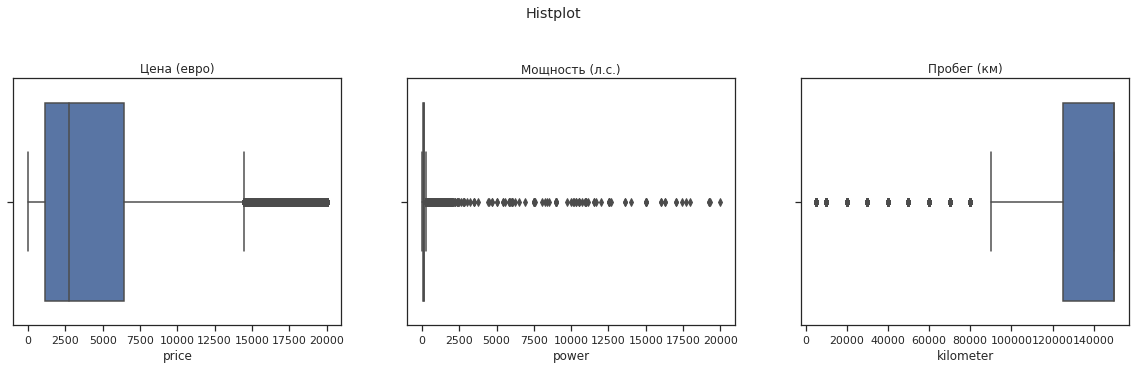

In [22]:
# посмотрим на распределения 

fig = plt.figure(figsize=(20,10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)

axes = [ax_1, ax_2, ax_3, ax_4]


sns.boxplot(data['price'], ax=ax_1)
sns.boxplot(data['power'], ax=ax_2)
sns.boxplot(data['kilometer'], ax=ax_3)

ax_1.set(title = 'Цена (евро)')
ax_2.set(title = 'Мощность (л.с.)')
ax_3.set(title = 'Пробег (км)')

fig.suptitle('Histplot');

Итак, видим, что у признака `power` очень много аномальных значений, и много значений, близких к нулю. 

In [23]:
data['power'].value_counts()

0       38204
75      24000
60      15881
150     14584
101     13292
        ...  
645         1
525         1
1922        1
6018        1
902         1
Name: power, Length: 712, dtype: int64

Посмотрим на дескриптивку. 

In [24]:
data.select_dtypes(include='number').describe()

,price,power,kilometer,number_of_pictures
count,352132.000000,352132.000000,352132.000000,352132.0
mean,4437.540570,110.720108,128438.071519,0.0
std,4516.540446,190.249667,37562.896848,0.0
min,0.000000,0.000000,5000.000000,0.0
25%,1100.000000,69.000000,125000.000000,0.0
50%,2750.000000,105.000000,150000.000000,0.0
75%,6450.000000,143.000000,150000.000000,0.0
max,20000.000000,20000.000000,150000.000000,0.0


У нас есть странные нулевые значения в признаках `price` и `power`.  В общем как-то нужно эти нули заменить, скорее всего это миссинги. Далее, перед обучением заменим нули на медианное значение.

Это с одной стороны. А с другой стороны, очень любопытно, что есть огромные значения больше 5000 л.с. Давайте посмотрим сколько таких значений. Сгруппируем еще по типу автомобильного кузова, мб это-то что даст.

In [25]:
data.loc[data['power'] > 5000].groupby('vehicle_type')['vehicle_type'].count()

vehicle_type
bus             6
convertible     4
coupe           2
other           3
sedan          16
small          24
wagon          15
Name: vehicle_type, dtype: int64

Итак, в базе 82 записи, где указана мощность у транспортного средства более 5000 л.с. Это менее 0,3%. Предлагаю от них избавиться. 

In [26]:
data.drop(data.loc[data['power'] > 5000].index, inplace=True)

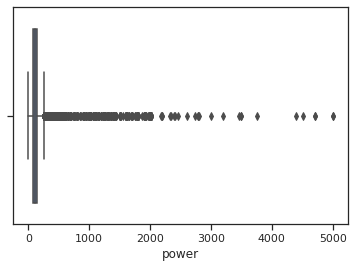

In [27]:
# посмотрим на распределения 
sns.boxplot(data['power']);

Если смотреть на выбросы с точки зрения того, что объекты удалены от третьего квартила больше чем на 3 межквартильных размаха, то аномальные значения еще остаются. Но удалять эти выбросы представляется неразумным, поскольку мощности машин могут достигать до 5 тыс. л.с. 

Выбросы признака `price` не сильные. Можно проверить эту гипотезу.

In [28]:
q1 = data[['price']].quantile(0.25)
q3 = data[['price']].quantile(0.75)
iqr = q3 - q1

(
    data['price']
    .apply(lambda x: 
           True if ((x < (float(q1) - 3 * float(iqr))) or (x > (float(q3) + 3 * float(iqr)))) 
           else False)
).value_counts()

False    352050
Name: price, dtype: int64

Убедились, что действительно нет объектов, которые удалены от третьего квартила больше чем на 3 межквартильных размаха.

Итак, от выбросов избавилиись. Перейдем к проверке дублей. 

#### Дубли

Сначала посмотрим на полные дубли. 
Посмотрим на дубли по переменной `postal_code` — почтовый индекс владельца анкеты (пользователя), а потом посмотрим на сочетания `postal_code` с другими признаками, а именно: `vehicle_type` — тип автомобильного кузова, `registration_year` — год регистрации автомобиля, `model` — модель автомобиля, `brand` — марка автомобиля.

In [29]:
(
    data
    .duplicated().sum()
)

4

В базе есть 4 полных дубля. Удалим их. 

In [30]:
data = data.drop_duplicates().reset_index(drop=True)

In [31]:
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [32]:
data.loc[data['model'] == 'rangerover', 'model'] = 'range_rover'

In [33]:
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Полные дубли удалили. Теперь посмотрим на дубли по сочетанию признаков (неявные дубли).

In [34]:
(
    data[['postal_code']]
    .duplicated().sum()
)

343905

Это было ожидаемо, потому что почтовый индекс может быть одинаковым у многих пользователей. Посмотрим на сочетание.

In [35]:
(
    data[['postal_code', 'brand', 'model', 'vehicle_type', 'registration_year']]
    .duplicated().sum()
)

64021

Ого! Таких дублей что-то прямо совсем много. Может быть стоить добавить в `registration_month` и `gearbox`.

In [36]:
(
    data[['postal_code', 'brand', 'model', 'vehicle_type', 'registration_year', 'registration_month', 'gearbox']]
    .duplicated().sum()
)

47082

Все равно дублей как-то многовато остаетсят. Глянем на первые 10 записей.

In [37]:
(
    data.loc[data[['postal_code', 'brand', 'model', 'vehicle_type', 'registration_year', 'registration_month', 'gearbox']]
    .duplicated(keep='first')==True].sort_values(by=['postal_code','brand', 'model',]).head()
)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7373,2016-03-24 17:52:09,16000,sedan,2014,auto,150,a3,20000,3,gasoline,audi,no,2016-03-24 00:00:00,0,10115,2016-03-24 17:52:09
10701,2016-03-24 14:54:51,16000,sedan,2014,auto,150,a3,20000,3,gasoline,audi,no,2016-03-24 00:00:00,0,10115,2016-03-24 15:42:42
15610,2016-03-10 13:58:16,9500,sedan,2012,auto,170,a3,80000,6,gasoline,audi,no,2016-03-10 00:00:00,0,10115,2016-03-10 13:58:16
17227,2016-03-23 19:54:01,9500,sedan,2012,auto,170,a3,80000,6,gasoline,audi,no,2016-03-23 00:00:00,0,10115,2016-03-23 19:54:01
32897,2016-03-19 13:51:40,16000,sedan,2014,auto,150,a3,20000,3,gasoline,audi,no,2016-03-19 00:00:00,0,10115,2016-03-19 13:51:40


Что видим: нужно добавить в проверку дублей признак `power`, `fuel_type` и `kilometer`. Посмотрим еще раз сколько останется. Если все еще много дублей, то добавим `date_created`. В основном предполагаемые дубли отличаются по признакам `date_crawled	` - дата выгрузки анкеты и `last_seen` - дата последней активности пользователя. Думаю, что ими можно пренебречь. 

In [38]:
(
    data[['postal_code', 'brand', 'model', 
                   'vehicle_type', 'registration_year', 
                   'registration_month', 'gearbox',
                  'power', 'kilometer', 'fuel_type']]
    .duplicated().sum()
)

39098

In [39]:
(
    data[['postal_code', 'brand', 'model', 
          'vehicle_type', 'registration_year', 
          'registration_month', 'gearbox',
          'power', 'kilometer', 'fuel_type',
          'date_created']]
    .duplicated().sum()
)

13524

Итак, по этим признакам у нас еще выявлено 13524 потенциальных дублей (что приблизительно 4% от данных). Посмотрим на них ближе, выясним чем они отличаются друг от друга.  

In [40]:
(
    data.loc[data[['postal_code', 'brand', 'model', 
                   'vehicle_type', 'registration_year', 
                   'registration_month', 'gearbox',
                   'power', 'kilometer', 'fuel_type',
                   'date_created']]
    .duplicated(keep=False)==True].sort_values(by=['postal_code','brand', 'model']).head()
)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3097,2016-03-26 20:36:56,9500,sedan,2012,auto,170,a3,80000,6,gasoline,audi,no,2016-03-26 00:00:00,0,10115,2016-03-26 20:36:56
7373,2016-03-24 17:52:09,16000,sedan,2014,auto,150,a3,20000,3,gasoline,audi,no,2016-03-24 00:00:00,0,10115,2016-03-24 17:52:09
10701,2016-03-24 14:54:51,16000,sedan,2014,auto,150,a3,20000,3,gasoline,audi,no,2016-03-24 00:00:00,0,10115,2016-03-24 15:42:42
15610,2016-03-10 13:58:16,9500,sedan,2012,auto,170,a3,80000,6,gasoline,audi,no,2016-03-10 00:00:00,0,10115,2016-03-10 13:58:16
17227,2016-03-23 19:54:01,9500,sedan,2012,auto,170,a3,80000,6,gasoline,audi,no,2016-03-23 00:00:00,0,10115,2016-03-23 19:54:01


In [41]:
# посмотрим сколько дублей останется если еще добавить переменную price
(
    data[['postal_code', 'brand', 'model', 
                   'vehicle_type', 'registration_year', 
                   'registration_month', 'gearbox',
                  'power', 'kilometer', 'fuel_type', 
          'date_created',
          'price']]
    .duplicated().sum()
)

11490

Если добавляем `price`, то дубли уменьшаются. Интересно посмотреть, есть ли среди предполагаемых дублей записи, где `price` указали равным 0.

In [42]:
(
    data.loc[(data[['postal_code', 'brand', 'model', 
                   'vehicle_type', 'registration_year', 
                   'registration_month', 'gearbox',
                   'power', 'kilometer', 'fuel_type',
                   'date_created']]
    .duplicated(keep=False)==True) & (data['price']==0)]
    .sort_values(by=['postal_code','brand', 'model', 'registration_year'])
    .head()
)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
117500,2016-03-10 21:48:33,0,coupe,2003,manual,143,c_klasse,150000,6,petrol,mercedes_benz,no,2016-03-10 00:00:00,0,10405,2016-03-11 10:44:50
184769,2016-03-10 17:47:46,0,coupe,2003,manual,143,c_klasse,150000,6,petrol,mercedes_benz,no,2016-03-10 00:00:00,0,10405,2016-03-10 17:47:46
76047,2016-03-15 20:52:12,0,NaN,2017,manual,70,golf,150000,3,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,12524,2016-03-16 19:17:09
120471,2016-03-14 07:55:40,0,NaN,2017,manual,70,golf,150000,3,petrol,volkswagen,NaN,2016-03-14 00:00:00,0,12524,2016-03-14 09:44:45
226416,2016-03-14 18:41:12,0,NaN,2017,manual,70,golf,150000,3,petrol,volkswagen,NaN,2016-03-14 00:00:00,0,12524,2016-03-15 13:45:02


In [43]:
(
    data.loc[(data[['postal_code', 'brand', 'model', 
                   'vehicle_type', 'registration_year', 
                   'registration_month', 'gearbox',
                   'power', 'kilometer', 'fuel_type',
                   'date_created']]
    .duplicated(keep=False)==True) & (data['price']==0)]
    .shape[0]
)

553

Да, такие данные есть и таких записей - 553. Но любопытно, что дубли отличаются друг от друга признаками `date_crawled` (датой скачивания анкеты из базы) и `last_seen` (датой последней активности пользователя), все остальное буквально идентично. Я предлагаю избавиться от таких дублей, вне зависимости от значений `price`, оставим последнюю запись как оригинальную. Так удалим примерно 3,3% от данных.

In [44]:
(
    data.drop_duplicates(subset=['postal_code', 'brand', 'model', 
                                 'vehicle_type', 'registration_year', 
                                 'registration_month', 'gearbox',
                                 'power', 'kilometer', 'fuel_type', 
                                 'date_created', 'price'], 
                         keep='last', 
                         inplace=True)
)

**Краткий вывод** 

Избавились от странных дублей. 

Перейдем к перекодировке категориальных признаков, их масштабированию и заполнению миссингов. 

#### Перекодировка данных и замена миссингов

In [45]:
# еще раз посмотрим на наши признаки
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340556 entries, 0 to 352045
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        340556 non-null  object
 1   price               340556 non-null  int64 
 2   vehicle_type        305825 non-null  object
 3   registration_year   340556 non-null  object
 4   gearbox             323316 non-null  object
 5   power               340556 non-null  int64 
 6   model               323357 non-null  object
 7   kilometer           340556 non-null  int64 
 8   registration_month  340556 non-null  object
 9   fuel_type           310339 non-null  object
 10  brand               340556 non-null  object
 11  not_repaired        273449 non-null  object
 12  date_created        340556 non-null  object
 13  number_of_pictures  340556 non-null  int64 
 14  postal_code         340556 non-null  object
 15  last_seen           340556 non-null  object
dtypes:

План: 

- сначала создам столбцы для дня недели, месяца и года создания объявления, включим их при обучении моделей;
- оставлю только те признаки, которые буду использовать при обучении моделей;  
- перекодирую категориальные признаки при помощи One-Hot-Encoding. 

In [46]:
data['date_created'].head()

0    2016-03-24 00:00:00
1    2016-03-24 00:00:00
2    2016-03-14 00:00:00
3    2016-03-17 00:00:00
4    2016-03-31 00:00:00
Name: date_created, dtype: object

In [47]:
# создание новых столбцов для даты
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')

In [48]:
data['weekday_created'] = data['date_created'].dt.weekday
data['month_created'] = data['date_created'].dt.month
data['year_created'] = data['date_created'].dt.year

In [49]:
# удаление неиспользуемых признаков
data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1, inplace=True)

In [50]:
# перекодировка признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340556 entries, 0 to 352045
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               340556 non-null  int64 
 1   vehicle_type        305825 non-null  object
 2   registration_year   340556 non-null  object
 3   gearbox             323316 non-null  object
 4   power               340556 non-null  int64 
 5   model               323357 non-null  object
 6   kilometer           340556 non-null  int64 
 7   registration_month  340556 non-null  object
 8   fuel_type           310339 non-null  object
 9   brand               340556 non-null  object
 10  not_repaired        273449 non-null  object
 11  weekday_created     340556 non-null  int64 
 12  month_created       340556 non-null  int64 
 13  year_created        340556 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 39.0+ MB


In [51]:
# изменим тип признака year_created с числового на текстовый
data['year_created'] = data['year_created'].astype(str)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340556 entries, 0 to 352045
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               340556 non-null  int64 
 1   vehicle_type        305825 non-null  object
 2   registration_year   340556 non-null  object
 3   gearbox             323316 non-null  object
 4   power               340556 non-null  int64 
 5   model               323357 non-null  object
 6   kilometer           340556 non-null  int64 
 7   registration_month  340556 non-null  object
 8   fuel_type           310339 non-null  object
 9   brand               340556 non-null  object
 10  not_repaired        273449 non-null  object
 11  weekday_created     340556 non-null  int64 
 12  month_created       340556 non-null  int64 
 13  year_created        340556 non-null  object
dtypes: int64(5), object(9)
memory usage: 39.0+ MB


Перед кодировкой категориальных переменных сначала нужно будет как-то обработать миссинги. Например, большую часть миссингов в `vehicle_type` можно будет заменить, ориентируясь на модель автомобиля. Пропуски в признаке `model` заменим на `unknown`. А признак `not_repaired` заменим миссинги, предполагая, что продавец пропуская ответ имел ввиду, что машина не была в ремонте.

In [53]:
# заполним пропуски в model
data['model'] = data['model'] .fillna("unknown")

In [54]:
data[data["model"]=="unknown"]["model"].count() # посмотрим сколько таких значений

17199

In [55]:
# создадим словарь, где в качестве ключа будет название модели, а значение - тип кузова
models_vechile_type = data.groupby('model')['vehicle_type'].agg(lambda x:x.value_counts().index[0]).to_dict()

# напишем функцию, которая заменит 
def vehicle_type_inputer(row):
    model = row["model"]
    vech_type = row["vehicle_type"]
    if model == "unknown" and vech_type == "unknown":
        return "unknown"
    elif model == "unknown" and vech_type != "unknown":
        return vech_type
    return models_vechile_type[model]

# сначала заполним пропуски в vehicle_type тоже как unknown 
data["vehicle_type"] = data["vehicle_type"].fillna("unknown")

# применим функцию 
data["vehicle_type"] = data[["vehicle_type", "model"]].apply(vehicle_type_inputer, axis=1)

In [56]:
data[data["vehicle_type"]=="unknown"]["vehicle_type"].count() # проверим

4526

In [57]:
# посмотрим сколько миссингов осталось и в каких признаках
data.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox               17240
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             30217
brand                     0
not_repaired          67107
weekday_created           0
month_created             0
year_created              0
dtype: int64

In [58]:
# посмотрим на значения признака not_repaired
data['not_repaired'].value_counts()

no     238227
yes     35222
Name: not_repaired, dtype: int64

In [59]:
# считаем, что если not_repaired пропущено, то продавец имел ввиду отсутствие ремонта
data['not_repaired'].fillna('yes', inplace=True) 

data.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox               17240
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             30217
brand                     0
not_repaired              0
weekday_created           0
month_created             0
year_created              0
dtype: int64

Очень много пропусков в признаке `fuel_type` (тип топлива). Думаю, что эти пропуски можно заменить по тому же принципу, как заменяли пропуски для `vehicle_type`. Там, где модель неизвестна (`unknown`), тип топлива тоже сделаем неизвестным (`unknown`). 

In [60]:
# сначала заполним пропуски в fuel_type тоже как unknown 
data["fuel_type"] = data["fuel_type"].fillna("unknown")

In [61]:
data.loc[data['model'] == 'unknown','fuel_type'].value_counts()

petrol      9043
unknown     4872
gasoline    2805
lpg          339
other         71
hybrid        25
electric      24
cng           20
Name: fuel_type, dtype: int64

In [62]:
data.pivot_table(index=['model'], 
                 columns=['fuel_type'],
                 values=['brand'],
                 aggfunc=['count'])

count                                                     
           brand                                                     
fuel_type    cng electric gasoline hybrid   lpg other  petrol unknown
model                                                                
100          NaN      NaN     15.0    NaN   7.0   NaN   345.0    35.0
145          NaN      NaN      1.0    NaN   NaN   NaN    42.0     5.0
147          NaN      NaN    120.0    NaN  17.0   NaN   380.0    31.0
156          NaN      NaN    180.0    NaN  15.0   NaN   348.0    58.0
159          NaN      NaN    136.0    NaN   NaN   NaN    56.0    12.0
...          ...      ...      ...    ...   ...   ...     ...     ...
yaris        NaN      NaN     92.0   19.0   NaN   NaN   840.0    51.0
yeti         NaN      NaN     78.0    NaN   NaN   NaN    84.0     3.0
ypsilon      NaN      NaN      6.0    NaN   1.0   NaN   166.0    23.0
z_reihe      NaN      NaN      2.0    NaN  10.0   NaN   661.0    22.0
zafira     114.0      NaN   1135.0    1.0  83.0   NaN  1328.0   252.0

[250 rows x 8 columns]

Скорее всего заменить `fuel_type` по такому же принципу, как выше для типа кузова не получится. Оставим как `unknown`.

In [63]:
# проверим какую долю от всех данных занимает тип `unknown`
data['fuel_type'].value_counts() / len(data) *100

petrol      61.402236
gasoline    27.914352
unknown      8.872843
lpg          1.495496
cng          0.162969
hybrid       0.066949
other        0.059021
electric     0.026134
Name: fuel_type, dtype: float64

Почти 9%. Проверим, отличается ли распределение целевого признака `price` для разных типов топлива. 

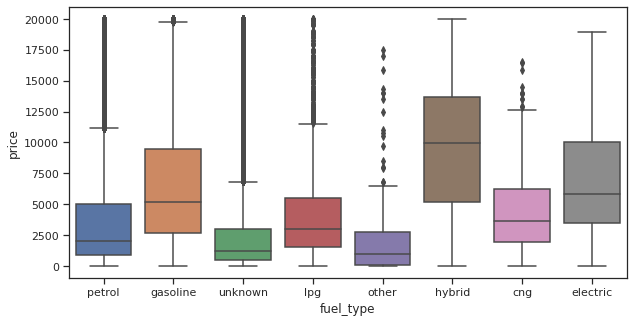

In [64]:
fig = plt.figure(figsize=(10,5))

sns.boxplot(x = data['fuel_type'],
            y = data['price']);

Сложно сказать, судя по диаграмме распределение цены по типу `unknown` практически не отличается от `other`. В общем, оставим так как заменили. 

Проверим оставшиеся миссинги в `gearbox`. 

In [65]:
data.pivot_table(index=['model'], 
                 columns=['gearbox'],
                 values=['brand'],
                 aggfunc=['count'])

count        
         brand        
gearbox   auto  manual
model                 
100       62.0   322.0
145        NaN    39.0
147       28.0   497.0
156       44.0   529.0
159       26.0   177.0
...        ...     ...
yaris     91.0   881.0
yeti      30.0   134.0
ypsilon   14.0   172.0
z_reihe   76.0   603.0
zafira   289.0  2473.0

[250 rows x 2 columns]

Некоторые миссинги можно заполнить, ориентируясь на модель машины. Заполним также `unknown`

In [66]:
# сначала заполним пропуски в gearbox тоже как unknown 
data["gearbox"] = data["gearbox"].fillna("unknown")

**Краткие выводы**

Итак, мы провели замену миссингов в категориальных переменных. 

Теперь разберемся с нулями в признаках `price` и `power`.

In [67]:
data[data['price'] == 0].shape

(9807, 14)

In [68]:
data[data['power'] == 0].shape

(37524, 14)

Но для начала заменим нули в `power` и `price` на миссинги, затем разделим выборку на тестовую и обучающую, проведем масштабирование данных. И только после этого проведем импутацию миссингов. 

Прежде чем проводить проводить импутацию миссингов, проверим корреляции между признаками. 

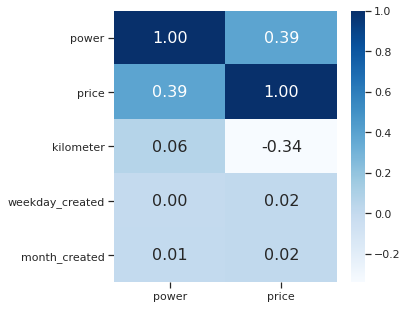

In [69]:
# проверим корреляции 
plt.figure(figsize=(5,5))
(
    sns.heatmap(data[['power', 'price', 'kilometer', 'weekday_created', 'month_created']]
                .corr()[['power', 'price']], 
                annot=True, 
                cmap="Blues", 
                fmt='.2f', 
                annot_kws={'size':16})
);

In [70]:
# замена 0 в power на миссинги
data['power'].replace(0, np.nan, inplace=True)
data['price'].replace(0, np.nan, inplace=True)

In [71]:
# проведем замену
data['power'] = data['power'].fillna(data['power'].median())
data['price'] = data['price'].fillna(data['price'].median())

In [72]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,weekday_created,month_created,year_created
0,480.0,sedan,1993,manual,110.0,golf,150000,0,petrol,volkswagen,yes,3,3,2016
1,18300.0,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,3,3,2016
2,9800.0,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,yes,0,3,2016
3,1500.0,sedan,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,3,3,2016
4,3600.0,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,3,3,2016


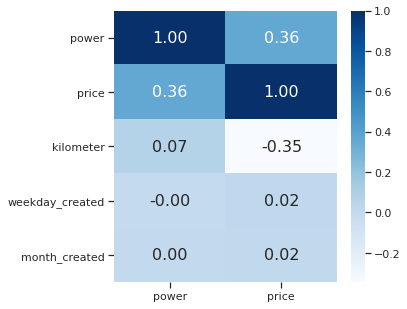

In [73]:
# проверим корреляции после импутации
plt.figure(figsize=(5,5))
(
    sns.heatmap(data[['power', 'price', 'kilometer', 'weekday_created', 'month_created']]
                .corr()[['power', 'price']], 
                annot=True, 
                cmap="Blues", 
                fmt='.2f', 
                annot_kws={'size':16})
);

**Краткий вывод**

Корреляции между некоторыми признаками немного изменились, но в целом теснота связи не изменилась. 

Теперь можно проделать перекодировку. Перекодированные значения сохраним в отдельном датасете. 

In [74]:
# перекодируем категориальные переменные
data_ohe = pd.get_dummies(data, drop_first=True)

In [75]:
data_ohe.head()

,price,power,kilometer,weekday_created,month_created,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes,year_created_2015,year_created_2016
0,480.0,110.0,150000,3,3,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
1,18300.0,190.0,125000,3,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,9800.0,163.0,125000,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1500.0,75.0,150000,3,3,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
4,3600.0,69.0,90000,3,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [76]:
# перекодируем категориальные переменные

# создам функцию 
def encoder(data, categorical):
    encoder = OrdinalEncoder()
    encoder.fit(data[categorical])
    data.loc[:, [categorical]] = encoder.transform(data[categorical])
    return data

In [77]:
data_ordinal = data.copy()

categorical = ['vehicle_type', 'registration_year', 'gearbox', 'model',
              'registration_month', 'fuel_type', 'brand', 'not_repaired', 
              'year_created']

encoder = OrdinalEncoder()

encoder.fit(data_ordinal[categorical])

data_ordinal.loc[:, categorical] = encoder.transform(data_ordinal[categorical])


In [78]:
data_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,weekday_created,month_created,year_created
0,480.0,4.0,83.0,1.0,110.0,116.0,150000,0.0,6.0,38.0,1.0,3,3,2.0
1,18300.0,2.0,101.0,1.0,190.0,227.0,125000,8.0,2.0,1.0,1.0,3,3,2.0
2,9800.0,6.0,94.0,0.0,163.0,117.0,125000,11.0,2.0,14.0,1.0,0,3,2.0
3,1500.0,4.0,91.0,1.0,75.0,116.0,150000,9.0,6.0,38.0,0.0,3,3,2.0
4,3600.0,5.0,98.0,1.0,69.0,101.0,90000,10.0,2.0,31.0,0.0,3,3,2.0


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340556 entries, 0 to 352045
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               340556 non-null  float64
 1   vehicle_type        340556 non-null  object 
 2   registration_year   340556 non-null  object 
 3   gearbox             340556 non-null  object 
 4   power               340556 non-null  float64
 5   model               340556 non-null  object 
 6   kilometer           340556 non-null  int64  
 7   registration_month  340556 non-null  object 
 8   fuel_type           340556 non-null  object 
 9   brand               340556 non-null  object 
 10  not_repaired        340556 non-null  object 
 11  weekday_created     340556 non-null  int64  
 12  month_created       340556 non-null  int64  
 13  year_created        340556 non-null  object 
dtypes: float64(2), int64(3), object(9)
memory usage: 47.0+ MB


#### Масштабирование данных

Перейдем к стандартизации признаков. Разделим сначала выборку на обучающую и тестовую. Причем придется два раза сделать: для `data` и `data_ohe` (с dummy-переменными).

In [80]:
# разделим выборку на обучающую и тестовая 
target = data['price']
features = data.drop(['price'], axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [81]:
numeric = ['power', 'kilometer', 'weekday_created', 'month_created']

In [82]:
# стандартизируем выборку
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])

# преобразуем тестовую выборки
features_test[numeric] = scaler.transform(features_test[numeric])

Стандатизировали датасет `data`. Теперь перейдем к `data_ohe`. 

In [83]:
# разделим выборку на обучающую и валидационную data_ohe
features_ohe = data_ohe.drop(['price'], axis=1)
features_ohe_train, features_ohe_test = train_test_split(
    features_ohe, test_size=0.25, random_state=12345)

In [84]:
# стандартизируем выборку
scaler = StandardScaler()
scaler.fit(features_ohe_train[numeric]) 
features_ohe_train[numeric] = scaler.transform(features_ohe_train[numeric])

# преобразуем тестовую выборки
features_ohe_test[numeric] = scaler.transform(features_ohe_test[numeric])

In [85]:
# разделим выборку на обучающую и валидационную data_ohe
features_ordinal = data_ordinal.drop(['price'], axis=1)
features_ordinal_train, features_ordinal_test = train_test_split(
    features_ordinal, test_size=0.25, random_state=12345)

In [86]:
# стандартизируем выборку
scaler = StandardScaler()
scaler.fit(features_ordinal_train[numeric]) 
features_ordinal_train[numeric] = scaler.transform(features_ordinal_train[numeric])

# преобразуем тестовую выборки
features_ordinal_test[numeric] = scaler.transform(features_ordinal_test[numeric])

**Вывод по предобработке данных**

Итак, в этой части провела предобработку данных: избавилась от дублей, удалила сильные выбросы, обработала миссинги. 

Перейдем к исследовательскому анализу данных и обучению моделей. 

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

С аномальными значениями и пропусками успешно справились 👍
</div>

## Обучение моделей

### Исследовательский анализ данных

В этом пункте посмотрим на корреляции между признаками, чтобы понять какие признаки оставить.

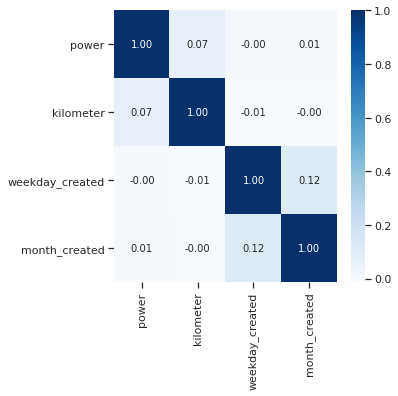

In [87]:
# проверим как скоррелированы переменные друг с другом. 
# если есть сильные корреляции, то исключим из анализа некоторые переменные

plt.figure(figsize=(5,5))
(
    sns.heatmap(features_train
                .corr(), 
                annot=True, 
                cmap="Blues", 
                fmt='.2f', 
                annot_kws={'size':10})
);

**Краткий вывод**

Как видно из диаграммы heatmap все корреляции между признаками довольно небольшие. Все числовые признаки можно оставить и использовать при построении модели.

### Построение моделей

Выберем следующие алгоритмы для обучения модели:

- `LinearRegression`
- `SGDRegressor`
- `DecisionTreeRegressor`
- `CatBoostRegressor`
- `LGBMRegressor`

В качестве метрики для всех моделей буду использовать `RMSE`. Качество моделей будем проверять на кроссвалидации.

Будем использовать два типа признаков для кроссвалидации:

- Неизмененные **(`features_ordinal_train`, `features_ordinal_test`)** для `CatBoostRegressor` и `LGBMRegressor`.
- Закодированные методом `OHE` (`features_ohe_train`, `features_ohe_test`) для `LinearRegression`, `SGDRegressor` и `DecisionTreeRegressor`. 

#### Линейная регрессия 

In [88]:
%%time
# время обучения

start_time = time.time()
linear_model = LinearRegression()

linear_model.fit(features_ohe_train, target_train)

linear_model_fit_time = time.time() - start_time

CPU times: user 41.3 s, sys: 35.8 s, total: 1min 17s
Wall time: 1min 17s


In [89]:
print(linear_model_fit_time)

77.50337767601013


In [90]:
print('RMSE для линейной регрессии на тренировочной выборке равен', 
      mean_squared_error(target_train, linear_model.predict(features_ohe_train), squared=False))

RMSE для линейной регрессии на тренировочной выборке равен 2315.9998079647885


In [91]:
%%time

# время предсказания
start_time = time.time()

target_linear_pred = linear_model.predict(features_ohe_test)

linear_model_predicted_time = time.time() - start_time

CPU times: user 120 ms, sys: 96.4 ms, total: 217 ms
Wall time: 218 ms


In [92]:
print('RMSE для линейной регрессии равен', mean_squared_error(target_test, target_linear_pred, squared=False))
print('R-score для линейной регрессии равен', r2_score(target_test, target_linear_pred))

RMSE для линейной регрессии равен 365024053328.0275
R-score для линейной регрессии равен -6765085950977845.0


In [93]:
linear_model_test_rmse = mean_squared_error(target_test, target_linear_pred, squared=False)

In [94]:
linear_model_test_rmse

365024053328.0275

Судя по всему, модель переобучилась. 

Качество модели оставляет желать лучшего. `R-score` отрицательный, `RMSE` довольно большой. Проверим еще качество модели на 
кросс-валидации. 

In [95]:
%%time

# Проверим качество модели на кросс-валидации
cv_rmse_linear_model = (cross_val_score(linear_model, 
                             features_ohe_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE на кросс-валидации равен', cv_rmse_linear_model)

RMSE на кросс-валидации равен 4020439285499.827
CPU times: user 2min 45s, sys: 2min 24s, total: 5min 9s
Wall time: 5min 10s


**Краткий вывод**

Модель обучалась чуть меньше минуты. Предсказывала модель почти секунду. Однако качество модели довольно низкое, в том числе на кросс-валидации. 

#### SGD Regressor

In [96]:
%%time

start_time = time.time()
sgd_regressor = SGDRegressor()

sgd_regressor.fit(features_ohe_train, target_train)

sgd_model_fit_time = time.time() - start_time

CPU times: user 12.9 s, sys: 437 ms, total: 13.3 s
Wall time: 13.4 s


In [97]:
sgd_model_train_rmse = mean_squared_error(target_train, sgd_regressor.predict(features_ohe_train),squared=False)

print('RMSE для SGD regressor для тренировочной выборки равен', 
      sgd_model_train_rmse)

RMSE для SGD regressor для тренировочной выборки равен 2335.538299865981


In [98]:
%%time

# время предсказания 
start_time = time.time()

target_sgd_pred = sgd_regressor.predict(features_ohe_test)

sgd_model_predicted_time = time.time() - start_time

CPU times: user 155 ms, sys: 139 ms, total: 293 ms
Wall time: 296 ms


In [99]:
sgd_model_test_rmse =  mean_squared_error(target_test, target_sgd_pred,squared=False)

In [100]:
print('RMSE для SGD regressor равен', sgd_model_test_rmse)
print('R-square для SGD regressor равен', r2_score(target_test, target_sgd_pred))

RMSE для SGD regressor равен 2332.4404199230526
R-square для SGD regressor равен 0.7237823221263988


In [101]:
%%time

# Проверим качество модели на кросс-валидации
cv_rmse_sgd_model = (cross_val_score(sgd_regressor, 
                             features_ohe_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE на кросс-валидации для SGD regressor равен', cv_rmse_sgd_model)

RMSE на кросс-валидации для SGD regressor равен 2350.2579126490605
CPU times: user 44.8 s, sys: 2.23 s, total: 47 s
Wall time: 47.3 s


**Краткий вывод**

ОГО! Круто! Благодаря кросс-валидации, смогла сильно уменьшить RMSE для модели. 

К тому время обучения и предсказания тоже низкие. Модель обучалась менее полуминуты, а предсказывала меньше секунды. 

#### Decision Tree Regression

Сначала хотела обучить случайный лес обучает очень долго. Я начинала подбор параметров в таких:
> `n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]`  
> `max_depth = [int(x) for x in np.linspace(10, 80, num = 11)]`

> `rf_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}`
> `forest_gsc = GridSearchCV(forest, rf_grid, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs=4)`

Но модель обучалась очень долго. Пробовала подобрать другие гиперпараметры, но время обучения не уменьшалось. В итоге решила обучить дерево решений. 

In [102]:
%%time

tree = DecisionTreeRegressor(random_state = 12345) 

# подберем гиперпараметры 
max_depth = [int(x) for x in np.linspace(10, 20, num = 10)]
hyperparams = {'max_depth':max_depth}

tree_gsc = GridSearchCV(tree, hyperparams, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs=4)

CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 504 µs


In [103]:
%%time

# обучение модели
result = tree_gsc.fit(features_ordinal_train, target_train)

CPU times: user 1.02 s, sys: 362 ms, total: 1.38 s
Wall time: 1min 3s


In [104]:
# посмотрим на результаты и лучшие параметры 
print('Decision Tree Regressor лучшее значение метрики neg_root_mean_squared_error: %s' % result.best_score_)
print('Decision Tree Regressor лучшие гиперпараметры: %s' % result.best_params_)

Decision Tree Regressor лучшее значение метрики neg_root_mean_squared_error: -2075.9640084960306
Decision Tree Regressor лучшие гиперпараметры: {'max_depth': 12}


In [105]:
%%time

start_time = time.time()

# сохраним в отдельной модели и обучим
tree = DecisionTreeRegressor(max_depth = 12, random_state = 12345) 

tree.fit(features_ordinal_train, target_train)

tree_model_fit_time = time.time() - start_time

CPU times: user 744 ms, sys: 0 ns, total: 744 ms
Wall time: 752 ms


In [106]:
%%time

# время предсказания 
start_time = time.time()

target_tree_pred = tree.predict(features_ordinal_test)

tree_model_predicted_time = time.time() - start_time

CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 16.8 ms


In [107]:
%%time

# Проверим качество модели на кросс-валидации
cv_rmse_tree_model = (cross_val_score(tree, 
                             features_ordinal_train, 
                             target_train, 
                             cv=2, # выборка большая
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE на кросс-валидации для Decision Tree regressor равен', cv_rmse_tree_model)

RMSE на кросс-валидации для Decision Tree regressor равен 2135.1802498420425
CPU times: user 863 ms, sys: 0 ns, total: 863 ms
Wall time: 868 ms


In [108]:
tree_model_test_rmse = mean_squared_error(target_test, target_tree_pred, squared=False)

In [109]:
print('RMSE для Decision Tree Regressor равен', tree_model_test_rmse)
print('R-square для Decision Tree Regressor равен', r2_score(target_test, target_tree_pred))

RMSE для Decision Tree Regressor равен 2034.3623264426915
R-square для Decision Tree Regressor равен 0.7898705317449433


**Краткий вывод**

Дерево решений дает чуть более лучший результат, но в целом, думаю, что результаты SGD regressor и дерева решений близки. Но обучается модель дольше. 

#### CatBoost Regression

Попробуем теперь методы градиентного бустинга. 

In [110]:
%%time

catboost = CatBoostRegressor(random_state=12345) 

# подберем гиперпараметры 
params_cat = {'iterations': [100], 'depth':[x for x in range (2,16,2)]}

catboost_gsc = GridSearchCV(catboost, params_cat, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs=4)

CPU times: user 180 µs, sys: 0 ns, total: 180 µs
Wall time: 185 µs


In [111]:
%%time

# обучение модели
catboost_gsc.fit(features_ordinal_train, target_train)

Learning rate set to 0.5
0:	learn: 3630.5986466	total: 74.9ms	remaining: 7.41s
1:	learn: 3279.7643994	total: 95.1ms	remaining: 4.66s
2:	learn: 3008.5743228	total: 120ms	remaining: 3.89s
3:	learn: 2852.1922480	total: 142ms	remaining: 3.41s
4:	learn: 2746.5806508	total: 160ms	remaining: 3.03s
5:	learn: 2648.5628446	total: 222ms	remaining: 3.48s
6:	learn: 2597.2033403	total: 241ms	remaining: 3.2s
7:	learn: 2563.0197371	total: 258ms	remaining: 2.97s
8:	learn: 2513.3820944	total: 286ms	remaining: 2.89s
9:	learn: 2490.3548731	total: 305ms	remaining: 2.75s
10:	learn: 2464.7657959	total: 363ms	remaining: 2.94s
11:	learn: 2446.6069293	total: 383ms	remaining: 2.81s
12:	learn: 2427.2524543	total: 464ms	remaining: 3.11s
13:	learn: 2413.0924975	total: 548ms	remaining: 3.37s
14:	learn: 2397.8714287	total: 565ms	remaining: 3.2s
15:	learn: 2389.2080235	total: 636ms	remaining: 3.34s
16:	learn: 2376.9930986	total: 660ms	remaining: 3.22s
17:	learn: 2358.5478170	total: 743ms	remaining: 3.38s
18:	learn: 23

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f85a814fa90>,
             n_jobs=4,
             param_grid={'depth': [2, 4, 6, 8, 10, 12, 14],
                         'iterations': [100]},
             scoring='neg_root_mean_squared_error')

In [112]:
catboost_gsc.best_params_

{'depth': 10, 'iterations': 100}

In [113]:
%%time

# сохраним модель с лучшими параметрами и обучим её
start_time = time.time()

catboost = CatBoostRegressor(depth = 10, iterations = 100, random_state=12345) 

catboost.fit(features_ordinal_train, target_train)

catboost_model_fit_time = time.time() - start_time

Learning rate set to 0.5
0:	learn: 3087.8083382	total: 75.3ms	remaining: 7.46s
1:	learn: 2495.5125193	total: 146ms	remaining: 7.16s
2:	learn: 2254.6328400	total: 216ms	remaining: 6.98s
3:	learn: 2151.7121256	total: 283ms	remaining: 6.8s
4:	learn: 2073.4645047	total: 354ms	remaining: 6.72s
5:	learn: 2036.2855309	total: 422ms	remaining: 6.62s
6:	learn: 2000.2170054	total: 494ms	remaining: 6.56s
7:	learn: 1985.2437081	total: 568ms	remaining: 6.53s
8:	learn: 1962.4259395	total: 640ms	remaining: 6.47s
9:	learn: 1944.6448858	total: 709ms	remaining: 6.38s
10:	learn: 1933.8412783	total: 784ms	remaining: 6.35s
11:	learn: 1922.7397076	total: 855ms	remaining: 6.27s
12:	learn: 1911.3762640	total: 926ms	remaining: 6.19s
13:	learn: 1899.6740370	total: 996ms	remaining: 6.12s
14:	learn: 1887.2582240	total: 1.07s	remaining: 6.05s
15:	learn: 1881.2262668	total: 1.14s	remaining: 5.99s
16:	learn: 1869.5138039	total: 1.21s	remaining: 5.91s
17:	learn: 1864.5107718	total: 1.28s	remaining: 5.86s
18:	learn: 18

In [114]:
%%time

# Проверим качество модели на кросс-валидации
cv_rmse_catboost_model = (cross_val_score(catboost, 
                             features_ordinal_train, 
                             target_train, 
                             cv=2, # поскольку выборка довольно большая
                             n_jobs=4, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

58:	learn: 1580.6616417	total: 27.3s	remaining: 19s
59:	learn: 1577.8372498	total: 28s	remaining: 18.7s
60:	learn: 1573.0127746	total: 28.5s	remaining: 18.2s
61:	learn: 1569.8238159	total: 29.1s	remaining: 17.8s
62:	learn: 1567.6638608	total: 29.7s	remaining: 17.4s
63:	learn: 1565.6352485	total: 30.1s	remaining: 16.9s
64:	learn: 1562.6267298	total: 30.5s	remaining: 16.4s
65:	learn: 1560.1328596	total: 30.9s	remaining: 15.9s
66:	learn: 1554.4355927	total: 31.3s	remaining: 15.4s
67:	learn: 1551.7527485	total: 31.8s	remaining: 15s
68:	learn: 1546.8732368	total: 32.2s	remaining: 14.5s
69:	learn: 1544.7689855	total: 32.6s	remaining: 14s
70:	learn: 1541.1448352	total: 33.3s	remaining: 13.6s
71:	learn: 1538.7881400	total: 33.7s	remaining: 13.1s
72:	learn: 1535.6189943	total: 34.2s	remaining: 12.6s
73:	learn: 1531.3924532	total: 34.6s	remaining: 12.1s
74:	learn: 1528.0815656	total: 35s	remaining: 11.7s
75:	learn: 1525.6409351	total: 35.5s	remaining: 11.2s
76:	learn: 1523.1084155	total: 35.9s	r

In [115]:
print('RMSE на кросс-валидации для CatBoostRegressor на трениворочных данных равен', cv_rmse_catboost_model)

RMSE на кросс-валидации для CatBoostRegressor на трениворочных данных равен 1831.7763635986607


In [116]:
%%time

start_time = time.time()

# проверим сколько времени требуется для предсказания и проверим качество модели на тестовой выборке
target_catboost_pred = catboost_gsc.predict(features_ordinal_test)

catboost_model_predicted_time = time.time() - start_time

CPU times: user 51.6 ms, sys: 3.1 ms, total: 54.7 ms
Wall time: 54.1 ms


In [117]:
catboost_model_test_rmse = mean_squared_error(target_test, target_catboost_pred ,squared=False)
print('RMSE CatBoostRegressor для тестовой выборки равен', 
      catboost_model_test_rmse)

RMSE CatBoostRegressor для тестовой выборки равен 1775.5893869505912


**Краткий вывод**

CatBoostReqressor показывает хорошие результаты, и время обучения и предсказания вполне приемлимые. Попробуем обучить еще одну модель.

#### LGBMRegressor

In [118]:
%%time

# подберем гиперпараметры
params_lgbm = {'max_depth':[x for x in range (2,16,2)]}

lgbm_model = LGBMRegressor(random_state=12345)

lgbm_model_gsc = GridSearchCV(estimator=lgbm_model, 
                              param_grid=params_lgbm,  
                              cv=5, 
                              n_jobs=4)

CPU times: user 44 µs, sys: 27 µs, total: 71 µs
Wall time: 73.2 µs


In [119]:
%%time

# обучение модели
lgbm_model_gsc.fit(features_ordinal_train, target_train)

CPU times: user 6.19 s, sys: 9.12 ms, total: 6.2 s
Wall time: 1min 22s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345), n_jobs=4,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14]})

In [120]:
lgbm_model_gsc.best_params_

{'max_depth': 12}

In [121]:
lgbm_model = LGBMRegressor(max_depth=12, 
                           random_state=12345, 
                           n_jobs=4)

In [122]:
%%time

# сохраним модель с лучшими параметрами и обучим её
start_time = time.time()

lgbm_model.fit(features_ordinal_train, target_train)

lgbm_model_fit_time = time.time() - start_time

CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.29 s


In [123]:
%%time

# Проверим качество модели на кросс-валидации
cv_rmse_lgbm_model = (cross_val_score(lgbm_model, 
                             features_ordinal_train, 
                             target_train, 
                             cv=2, # поскольку выборка довольно большая
                             n_jobs=4,       
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

CPU times: user 53.1 ms, sys: 0 ns, total: 53.1 ms
Wall time: 7.7 s


In [124]:
# вывод RMSE на тренировочной выборке
print('RMSE на кросс-валидации для LGBMRegressor на трениворочных данных равен', cv_rmse_catboost_model)

RMSE на кросс-валидации для LGBMRegressor на трениворочных данных равен 1831.7763635986607


In [125]:
%%time

start_time = time.time()

# проверим сколько времени требуется для предсказания и проверим качество модели на тестовой выборке
target_lgbm_pred = lgbm_model.predict(features_ordinal_test)

lgbm_model_predicted_time = time.time() - start_time

CPU times: user 598 ms, sys: 0 ns, total: 598 ms
Wall time: 582 ms


In [126]:
lgbm_model_test_rmse = mean_squared_error(target_test, target_lgbm_pred ,squared=False)

print('RMSE LGBMRegressor для тестовой выборки равен', 
      lgbm_model_test_rmse)

RMSE LGBMRegressor для тестовой выборки равен 1852.0750936787813


**Краткий вывод**

LGBMRegressor показал по ошибке измерения результаты почти такие же, как и CatBoostRegressor, но чуть похуже, но вероятнее всего разница может быть статистически незначимой. При это обучалась модель быстрее.

В следующем пункте сравним три показателя всех обученных моделей:

- качество предсказания;
- время обучения;
- время предсказания.

Основываясь на предпочтениях клиенты выберем наиболее подходящую модель. 

## Анализ моделей

In [127]:
index = ['LinearRegression',
         'SGDRegressor',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на кросс-валидации, евро':[cv_rmse_linear_model,
                                         cv_rmse_sgd_model,
                                         cv_rmse_tree_model,
                                         cv_rmse_catboost_model,
                                         cv_rmse_lgbm_model],
        'RMSE модели на тестовой выборке, евро':[linear_model_test_rmse,
                                                 sgd_model_test_rmse,
                                                 tree_model_test_rmse,
                                                 catboost_model_test_rmse,
                                                 lgbm_model_test_rmse],
        'Время обучения модели, мин':[linear_model_fit_time,
                                      sgd_model_fit_time, 
                                      tree_model_fit_time,
                                      catboost_model_fit_time,
                                      lgbm_model_fit_time],
        'Время предсказания модели, мин':[linear_model_predicted_time,
                                          sgd_model_predicted_time,
                                          tree_model_predicted_time,
                                          catboost_model_predicted_time,
                                          lgbm_model_predicted_time]}

scores_data = pd.DataFrame(data=data, index=index)

display(scores_data)

,"RMSE на кросс-валидации, евро","RMSE модели на тестовой выборке, евро","Время обучения модели, мин","Время предсказания модели, мин"
LinearRegression,4.020439e+12,3.650241e+11,77.503378,0.218018
SGDRegressor,2.350258e+03,2.332440e+03,13.377092,0.295565
DecisionTreeRegressor,2.135180e+03,2.034362e+03,0.751789,0.016756
CatBoostRegressor,1.831776e+03,1.775589e+03,8.251129,0.054050
LGBMRegressor,1.876304e+03,1.852075e+03,3.289951,0.582189


59:	learn: 1568.7641575	total: 27.8s	remaining: 18.6s
60:	learn: 1566.3820833	total: 28.3s	remaining: 18.1s
61:	learn: 1561.5454128	total: 28.7s	remaining: 17.6s
62:	learn: 1558.5691767	total: 29.1s	remaining: 17.1s
63:	learn: 1554.9231552	total: 29.6s	remaining: 16.6s
64:	learn: 1551.2341253	total: 30s	remaining: 16.1s
65:	learn: 1547.7030043	total: 30.5s	remaining: 15.7s
66:	learn: 1542.2187465	total: 30.9s	remaining: 15.2s
67:	learn: 1539.0613675	total: 31.3s	remaining: 14.7s
68:	learn: 1536.4942560	total: 31.7s	remaining: 14.2s
69:	learn: 1534.6504353	total: 32.2s	remaining: 13.8s
70:	learn: 1530.4457093	total: 32.6s	remaining: 13.3s
71:	learn: 1528.4604176	total: 33.1s	remaining: 12.9s
72:	learn: 1523.9441086	total: 33.6s	remaining: 12.4s
73:	learn: 1521.4065230	total: 34s	remaining: 12s
74:	learn: 1518.5527457	total: 34.8s	remaining: 11.6s
75:	learn: 1516.5315430	total: 35.2s	remaining: 11.1s
76:	learn: 1511.6776553	total: 35.7s	remaining: 10.7s
77:	learn: 1510.7871998	total: 36.

## Общий вывод


Сравнивая показатели в таблице, представляется разумным выбрать либо LGBMRegressor, либо CatBoostRegressor для предсказания стоимости автомобиля. CatBoostRegressor показывает лучшие наименьшее RMSE, но обучается модель долго. LGBMRegressor обучается относительно быстро, но дольше CatBoostRegressor предсказывает. 

Я бы предложила остановиться на модели LGBMRegressor. Возможно, что различия в RMSE у CatBoostRegressor и LGBMRegressor статистически значимо на отличаются. 